# Fiber Study
Wastyk et al. (2021) from the Sonnenburg Lab showed in a feeding study the inter-individual differences in inflammatory immune response after intervention with a high-fiber diet. Here, we use microbial sequencing data from this study to compare the results of MICOM metabolic modeling with the results obtained by the authors. Specifically, we are curious whether the SCFA production profiles from our metabolic models agree with the inflammatory immune response group used by the authors to categorize study participants

In [1]:
import pandas as pd
from plotnine import *
import numpy as np
import scipy
import micom
import micom.measures

%matplotlib inline

## Taxonomy Table
Load up the taxonomic abundances and build a taxonomy table for use in MICOM. We have a separate file with taxon names for each ASV that we will load as a dict and map onto the taxonomy table

In [3]:
taxonomy = pd.read_csv('../data/fiberstudy_abundances.csv') # Load abundance data
asv = pd.read_csv('../data/fiberstudy_ASVs.csv', index_col = 0)['0'].to_dict() # Load ASV file as a dict
taxonomy = taxonomy.rename(columns = asv) # Rename abundance data columns with ASV names
taxonomy['sample_id'] = taxonomy['participant'].astype('str')+'_'+taxonomy['timepoint'].astype('str') # Create unique IDs
taxonomy = taxonomy[taxonomy['group']=='Fiber'] # Filter to fiber treated samples
taxonomy = taxonomy[~(taxonomy['timepoint']==8)&~(taxonomy['timepoint']==9)] # Timepoints 8 and 9 are in the 'participant choice' part of the intervention
taxonomy = taxonomy.groupby(axis=1, level=0).sum()# Group duplicated columns
metadata = taxonomy.set_index('sample_id')[['participant','timepoint','immune_group']] # Save the metadata for future use
taxonomy = pd.melt(taxonomy,# Melt into a longform dataframe
                   id_vars = ['sample_id','participant','group','timepoint','immune_group'],
                   value_vars = taxonomy.columns[4:-1], 
                   var_name = 'id',
                   value_name = 'abundance')
taxonomy['genus'] = taxonomy['id'].str.split(';').str[5].str.split('.').str[0] # Add a genus column
taxonomy['genus'].replace('',np.nan, inplace = True)
taxonomy.dropna(how = 'any', inplace = True)
taxonomy

,sample_id,participant,group,timepoint,immune_group,id,abundance,genus
0,8001_1,8001,Fiber,1,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000000,Actinomyces
1,8001_2,8001,Fiber,2,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000211,Actinomyces
2,8001_3,8001,Fiber,3,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000000,Actinomyces
3,8001_4,8001,Fiber,4,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000000,Actinomyces
4,8001_5,8001,Fiber,5,HighInflammation,Bacteria;Actinobacteria;Actinobacteria;Actinom...,0.000000,Actinomyces
...,...,...,...,...,...,...,...,...
14989,8041_3,8041,Fiber,3,LowInflammationI,Bacteria;Verrucomicrobia;Verrucomicrobiae;Verr...,0.000000,Akkermansia
14990,8041_4,8041,Fiber,4,LowInflammationI,Bacteria;Verrucomicrobia;Verrucomicrobiae;Verr...,0.002774,Akkermansia
14991,8041_5,8041,Fiber,5,LowInflammationI,Bacteria;Verrucomicrobia;Verrucomicrobiae;Verr...,0.000000,Akkermansia
14992,8041_6,8041,Fiber,6,LowInflammationI,Bacteria;Verrucomicrobia;Verrucomicrobiae;Verr...,0.000000,Akkermansia


## Build Models
Now, we'll build our models, with cutoff of 0.001

In [5]:
models = micom.workflows.build(taxonomy,
                               out_folder = '../models/fiber_study',
                               model_db = '../agora103_refseq216_genus_1.qza',
                               cutoff = 0.001, 
                               threads = 10)

[16:16:48] WARNING  Found existing models for 126 samples. Will skip those. Delete the output folder if ]8;id=609295;file:///users/nbohmann/.local/lib/python3.8/site-packages/micom/workflows/build.py\build.py]8;;\:]8;id=232895;file:///users/nbohmann/.local/lib/python3.8/site-packages/micom/workflows/build.py#95\95]8;;\
                    you would like me to rebuild them.                                                             

Output()

## Load Medium
Load the high fiber medium we'll use for growth

In [2]:
medium = pd.read_csv('../media/highfiber.csv')

## Grow Models
Next, grow the samples with the high fiber medium and a tradeoff value of 0.7

In [7]:
manifest = pd.read_csv('../models/fiber_study/manifest.csv') # Read the model manifest
growth = micom.workflows.grow(manifest,
                              '../models/fiber_study',
                              medium=medium,
                              tradeoff=.7,
                              strategy='none',
                              threads = 20)

Output()

/users/nbohmann/.local/lib/python3.8/site-packages/micom/workflows/grow.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


## Calculate predicted SCFA production
Specifically, we'll look at butyrate and propioante production

In [8]:
production = micom.measures.production_rates(growth) # Calculate production
scfa = production[(production['metabolite']=='but[e]')|(production['metabolite']=='ppa[e]')] # Isolate butyrate and propoionate
scfa = pd.pivot(scfa,
                index = 'sample_id',
                columns = 'metabolite',
                values = 'flux') # Pivot data
scfa['immune_group'] = scfa.index.map(metadata['immune_group'].to_dict()) # Add immune group metadata
scfa['timepoint'] = scfa.index.map(metadata['timepoint'].to_dict()) # Add timepoint metadata

## Plot Results
Now, plot the predicted production among each inflammation group, at each timepoint across the intervention and average

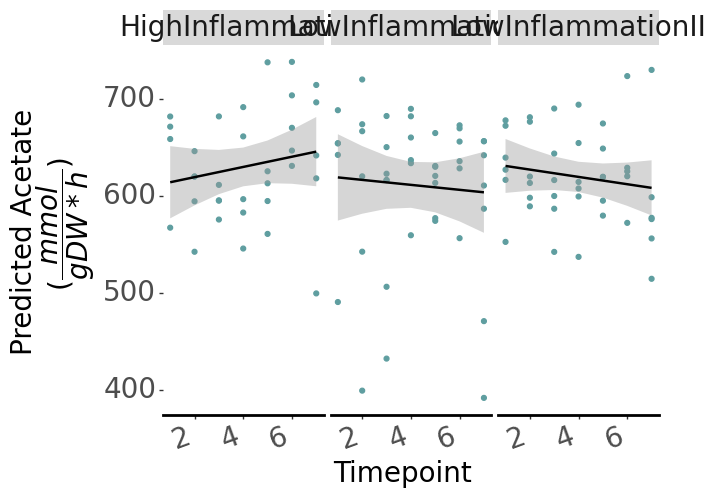

<ggplot: (8778159824107)>

In [9]:
plt1 = (ggplot(scfa,
    aes(x = 'timepoint', y = 'but[e]'))
    +geom_point(color = 'cadetblue')
    +geom_smooth(method = 'lm')
    +labs(x = 'Timepoint', y = 'Predicted Butyrate \n ($\dfrac{mmol}{gDW*h}$)')
    +facet_wrap(facets = 'immune_group')
    +theme(text = element_text(size=20),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                axis_line_y = element_blank(), axis_text_x=element_text(rotation = 20, hjust = 1)))
plt1

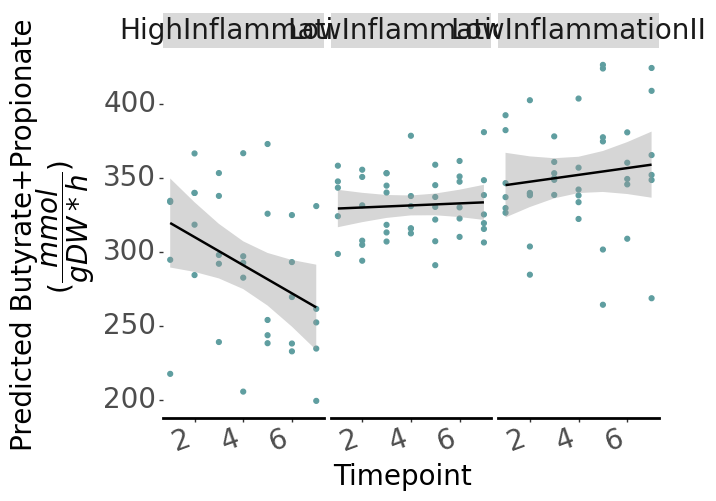

<ggplot: (8778344903671)>

In [10]:
plt2 = (ggplot(scfa,
    aes(x = 'timepoint', y = 'ppa[e]'))
    +geom_point(color = 'cadetblue')
    +geom_smooth(method = 'lm')
    +labs(x = 'Timepoint', y = 'Predicted Propionate \n ($\dfrac{mmol}{gDW*h}$)')
    +facet_wrap(facets = 'immune_group')
    +theme(text = element_text(size=20),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                axis_line_y = element_blank(), axis_text_x=element_text(rotation = 20, hjust = 1)))
plt2

Let's also look at average production across the entire intervention per immune group.

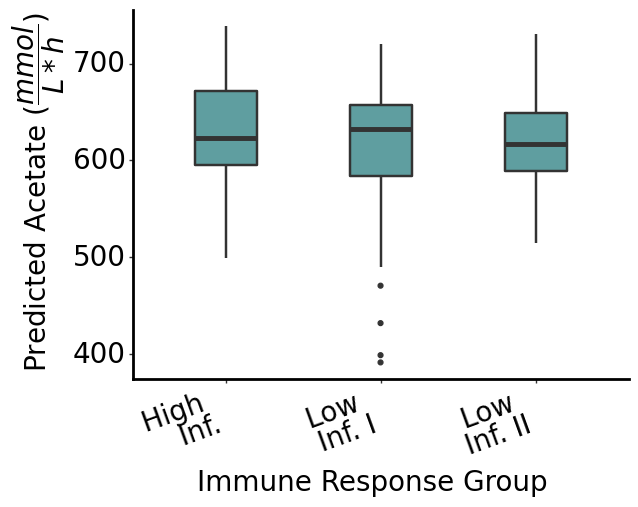

<ggplot: (8778352055706)>

In [11]:
plt3 = (ggplot(scfa, 
        aes(x = 'immune_group', y = 'but[e]'))
        +geom_boxplot(fill = 'cadetblue',size = 1, width = 0.4)
        +labs(x = 'Immune Response Group', y = 'Predicted Butyrate ($\dfrac{mmol}{L*h}$)')
        +scale_x_discrete(limits = ['HighInflammation','LowInflammationI','LowInflammationII'],
                          labels = ['High \n Inf.', 'Low \n Inf. I', 'Low \n Inf. II'])
        +theme(text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1)))
plt3

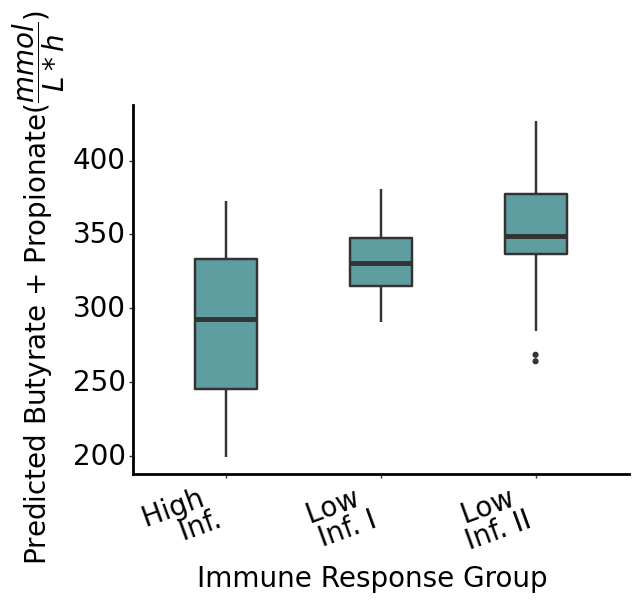

<ggplot: (8778353445042)>

In [12]:
plt4 = (ggplot(scfa,
        aes(x = 'immune_group', y = 'ppa[e]'))
        +geom_boxplot(fill = 'cadetblue',size = 1, width = 0.4)
        +labs(x = 'Immune Response Group', y = 'Predicted Propionate($\dfrac{mmol}{L*h}$)')
        +scale_x_discrete(limits = ['HighInflammation','LowInflammationI','LowInflammationII'],
                          labels = ['High \n Inf.', 'Low \n Inf. I', 'Low \n Inf. II'])
        +theme(text = element_text(size=20, color = 'black'),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_position='right',axis_text_x=element_text(rotation = 20, hjust = 1)))
plt4

## Save Results

In [13]:
scfa.to_csv('../results/fiberstudy.csv')